# Embeddings

In [1]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import Sequential

## Loading the data

In [2]:
with h5py.File('/cluster/home/rohrbjan/joint_scoring/labels_train.h5', 'r') as hf:
    labels_train = hf['labels_train'][:]
    
with h5py.File('/cluster/home/rohrbjan/joint_scoring/img_train.h5', 'r') as hf:
    img_train = hf['img_train'][:]

with h5py.File('/cluster/home/rohrbjan/joint_scoring/labels_test.h5', 'r') as hf:
    labels_test = hf['labels_test'][:]
    
with h5py.File('/cluster/home/rohrbjan/joint_scoring/img_test.h5', 'r') as hf:
    img_test = hf['img_test'][:]

print([labels_train.shape, img_train.shape])
print([labels_test.shape, img_test.shape])

[(72298,), (72298, 150, 150, 1)]
[(19611,), (19611, 150, 150, 1)]


In [3]:
# images need to be rgb (shape (150, 150, 3))
from IPython.display import clear_output
from PIL import Image

img_train_rgb = []

for i, img in enumerate(img_train):
    if i % 1000 == 0:
        clear_output()
        print("Converting train images to RGB, {0:.2f} % finished".format(i/72298*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_train_rgb.append(dat)
    
img_test_rgb = []
    
for i, img in enumerate(img_test):
    if i % 1000 == 0:
        clear_output()
        print("Converting train images to RGB, {0:.2f} % finished".format(i/72298*100))
    im = Image.fromarray((img.squeeze()).astype("int16"))
    im = im.convert("RGB")
    dat = np.array(im)
    img_test_rgb.append(dat)

Converting train images to RGB, 26.28 % finished


In [4]:
#img_train_rgb = np.array(img_train_rgb)
#img_test_rgb = np.array(img_test_rgb)

In [5]:
from tensorflow.python.keras.applications.inception_v3 import preprocess_input

img_train_rgb = [preprocess_input(x.astype("float32")) for x in img_train_rgb]
img_test_rgb = [preprocess_input(x.astype("float32")) for x in img_test_rgb]

In [6]:
img_train_rgb = np.array(img_train_rgb)
img_test_rgb = np.array(img_test_rgb)

In [7]:
from tensorflow.python.keras.models import load_model

loaded_model = load_model("/cluster/home/rohrbjan/joint_scoring/models/20171127_204852.h5")

In [9]:
pred = loaded_model.predict(imgs)

In [10]:
pred = pred.argmax(axis=-1)

In [11]:
diff = pred - y

In [12]:
diff

array([ 0.,  1., -1., ...,  0.,  1., -1.])

## Build truncated model

In [15]:
loaded_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 150, 150, 3)   0                                            
____________________________________________________________________________________________________
conv2d_377 (Conv2D)              (None, 74, 74, 32)    864         input_5[0][0]                    
____________________________________________________________________________________________________
batch_normalization_385 (BatchNo (None, 74, 74, 32)    96          conv2d_377[0][0]                 
____________________________________________________________________________________________________
activation_385 (Activation)      (None, 74, 74, 32)    0           batch_normalization_385[0][0]    
___________________________________________________________________________________________

In [8]:
from tensorflow.python.keras.models import Model
layer_name = 'activation_480'
model = Model(inputs=loaded_model.input, 
              outputs=loaded_model.get_layer(layer_name).output)

## Get embeddings

In [9]:
embeddings_train = model.predict(img_train_rgb)
embeddings_test = model.predict(img_test_rgb)

In [ ]:
from sklearn.decomposition import PCA

x_50d = PCA(n_components=50).fit_transform(embeddings)

In [33]:
from sklearn.manifold import TSNE

x_2d = TSNE(n_components=2, random_state=1).fit_transform(x_50d)

## 2D

In [34]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=y, cmap=plt.cm.get_cmap("viridis", 6))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_classification_transfer_learning.png', bbox_inches='tight')

In [35]:
from matplotlib import pyplot as plt

plt.figure(figsize=(25,25))
plt.scatter(x_2d[:, 0], x_2d[:, 1], c=diff, cmap=plt.cm.get_cmap("RdBu", 10))
plt.colorbar()
plt.savefig('/data/joint_scoring/images/tsne_diference_classification_transfer_learning.png', bbox_inches='tight')

## KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [11]:
weights = {0: 0.2468182438891165, 1: 0.61240428271328862, 2: 7.3563288563288562, 3: 15.980990274093722, 4: 27.700383141762451, 5: 12.358632478632479}

In [12]:
def weight(x):
    return np.vectorize(weights.get)(x.astype("int"))

In [27]:
#embeddings_train = embeddings[:72298]
#embeddings_test = embeddings[72298:]

In [28]:
embeddings.shape

(19611, 512)

In [77]:
cv_scores = []

kk = range(1,200,10)

for k in kk:
    print(k)
    knn = KNeighborsClassifier(n_neighbors=k, weights=weight)
    scores = cross_val_score(knn, embeddings, y, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

1


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

11


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

21


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

31


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

41


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

51


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

61


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

71


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

81


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

91


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

101


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

111


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

121


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

131


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

141


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

151


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

161


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

171


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

181


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

191


/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath

In [78]:
cv_scores

[0.61303017860121922,
 0.69160700149038179,
 0.70262052660336982,
 0.70741429124757071,
 0.70771937426761011,
 0.70797374853260231,
 0.70960635125805882,
 0.70914771382073793,
 0.71067551616649727,
 0.71011405637653335,
 0.71047052344022688,
 0.70914396484455455,
 0.70827781436946835,
 0.70807370640080802,
 0.70858258329426183,
 0.70751248148589574,
 0.70883836253497789,
 0.70939930213278057,
 0.70878791584231915,
 0.70878817609734535]

The optimal number of neighbors is 81


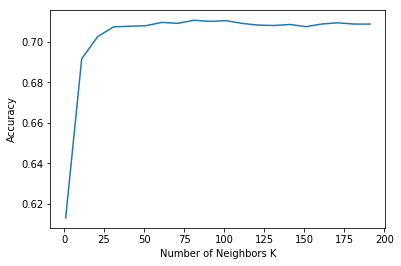

In [84]:
# determining best k
from matplotlib import pyplot as plt
optimal_k = kk[cv_scores.index(max(cv_scores))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.close()
plt.plot(kk, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy')
plt.show()

In [26]:
embeddings_train.shape

(19611, 512)

In [28]:
from sklearn.model_selection import cross_val_predict
knn = KNeighborsClassifier(n_neighbors=51, weights=weight)
knn = knn.fit(X=embeddings_train, y=labels_train)
pred = knn.predict(X=embeddings_test)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/extmath.py:439: RuntimeWarning: invalid value encountered in greater
  mostfrequent = np.where(counts > oldcounts, score, oldmostfreq)


Confusion matrix, without normalization
[[11146  2092    22     4     0    22]
 [ 2552  2644   103    27     5    38]
 [   51   235    67    32    12    26]
 [   13    70    34    29    10    21]
 [    2    29    16    16    11    24]
 [   14    42     6    22    12   162]]
Normalized confusion matrix
[[  8.38928195e-01   1.57458979e-01   1.65587837e-03   3.01068794e-04
    0.00000000e+00   1.65587837e-03]
 [  4.75321289e-01   4.92456696e-01   1.91842056e-02   5.02886944e-03
    9.31272118e-04   7.07766809e-03]
 [  1.20567376e-01   5.55555556e-01   1.58392435e-01   7.56501182e-02
    2.83687943e-02   6.14657210e-02]
 [  7.34463277e-02   3.95480226e-01   1.92090395e-01   1.63841808e-01
    5.64971751e-02   1.18644068e-01]
 [  2.04081633e-02   2.95918367e-01   1.63265306e-01   1.63265306e-01
    1.12244898e-01   2.44897959e-01]
 [  5.42635659e-02   1.62790698e-01   2.32558140e-02   8.52713178e-02
    4.65116279e-02   6.27906977e-01]]


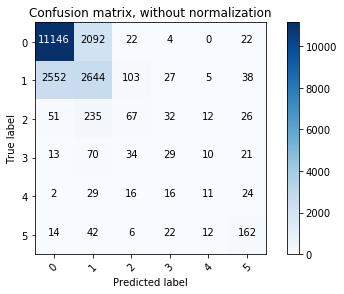

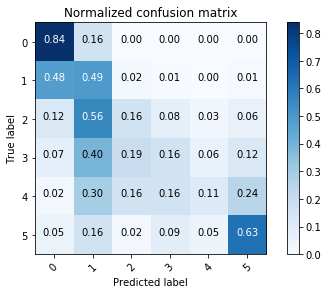

In [29]:
from matplotlib import pyplot as plt
plt.close()

from sklearn.metrics import confusion_matrix
import itertools
cnf_matrix = confusion_matrix(labels_test, pred)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(6),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(6), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [30]:
cm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
print("Mean accuracy per class")
print(np.mean(np.diag(cm)))

Mean accuracy per class
0.398961834757


In [31]:
upper = np.diag(cm, 1)
upper = np.append(upper, 0)
diagonal = np.diag(cm)
lower = np.diag(cm, -1)
lower = np.append(0, lower)

arr = np.vstack((upper, diagonal, lower))
print("Mean accuracy in the correct class or +- 1")
print(arr.sum(axis=0).mean())

Mean accuracy in the correct class or +- 1
0.730033936669


## 3D

In [17]:
from sklearn.manifold import TSNE
x_embedded = TSNE(n_components=3, random_state=1).fit_transform(x_50d)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(25,25))
ax = Axes3D(fig)
ax.scatter(x_embedded[:, 0], x_embedded[:, 1], x_embedded[:, 2], c=y, cmap=plt.cm.get_cmap("viridis", 6))
plt.savefig('/data/joint_scoring/images/tsne_3d_classification.png', bbox_inches='tight')

In [129]:
!pip3 install scikit-image --upgrade
from skimage.transform import resize
imgs_resized = [resize(image=x, output_shape=(50, 50)) for x in imgs]
imgs_resized = np.array(imgs_resized)

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.5/dist-packages
Requirement already up-to-date: matplotlib>=1.3.1 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: scipy>=0.17.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: six>=1.7.3 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: PyWavelets>=0.4.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pillow>=2.1.0 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: networkx>=1.8 in /usr/local/lib/python3.5/dist-packages (from scikit-image)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1.3.1->scikit-image)
Requirement already up-to-date: numpy>=1.7.1 in /usr/local/lib/python3.5/dist-packages (from matplotlib>=1

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [95]:
cm = plt.cm.get_cmap("viridis", 6)
color = np.ones((6, 4))
for i in range(6):
    color[i] = cm(1.*i/6)

#color = [x[0:-1] for x in color]
color = [np.append((x[0:-1] * 255),1) for x in color]
color = np.array(color)


color = color.astype("int16")

print(color)
print(type(color[0]))

[[ 68   1  84   1]
 [ 64  67 135   1]
 [ 41 120 142   1]
 [ 34 167 132   1]
 [121 209  81   1]
 [253 231  36   1]]
<class 'numpy.ndarray'>


In [96]:
tuple(color[0])

(68, 1, 84, 1)

In [117]:
y

62.845509

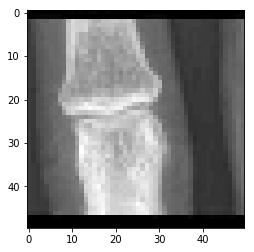

In [201]:
plt.imshow(imgs_resized[1].squeeze(), cmap="gray")
plt.show()

In [221]:
from PIL import Image
from PIL import ImageMath

imgs_border = []

old_size = (50, 50)
new_size = (54, 54)

for i, img in enumerate(imgs_resized):
    if i % 100 == 0:
        clear_output()
        print("Creating images with colored borders, {0:.2f} % finished".format(i/19611*100))
    old_im = Image.fromarray((img.squeeze()*255).astype("int16"))
    old_im = old_im.convert("RGB")
    new_im = Image.new("RGB", new_size, tuple(color[int(y[i])]))
    new_im.paste(old_im, (2,2))
    dat = np.asarray(a=new_im)
    imgs_border.append(dat)


Creating images with colored borders, 99.94 % finished


In [225]:
np.array(imgs_border).shape

(19611, 54, 54, 3)

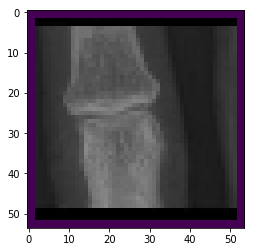

In [226]:
plt.imshow(imgs_border[1])
plt.show()

In [227]:
from IPython.display import clear_output
res = 8000 # resolution of plot
cval = 255 # background colour

images = imgs_border
max_width = max([image.shape[0] for image in images])
max_height = max([image.shape[1] for image in images])

In [228]:
f2d = x_2d

xx = f2d[:, 0]
yy = f2d[:, 1]
x_min, x_max = xx.min(), xx.max()
y_min, y_max = yy.min(), yy.max()
# Fix the ratios
sx = (x_max-x_min)
sy = (y_max-y_min)
if sx > sy:
    res_x = sx/float(sy)*res
    res_y = res
else:
    res_x = res
    res_y = sy/float(sx)*res

In [229]:
res_x, res_y

(8000, 8615.1535825786468)

In [230]:
res_y=res_y.astype("int16")

In [231]:
images[0].shape

(54, 54, 3)

In [232]:
canvas = np.ones((res_x+max_width, res_y+max_height, 3))*cval
x_coords = np.linspace(x_min, x_max, res_x)
y_coords = np.linspace(y_min, y_max, res_y)
i = 0
for x, y, image in zip(xx, yy, images):
    clear_output()
    print("Creating plot, {0:.2f} % finished".format(i/19611*100))
    i = i + 1
    w, h = image.shape[:2]
    x_idx = np.argmin((x - x_coords)**2)
    y_idx = np.argmin((y - y_coords)**2)
    canvas[x_idx:x_idx+w, y_idx:y_idx+h] = image

Creating plot, 99.99 % finished


In [ ]:
!rm /data/joint_scoring/images/embeddings_classification.png

In [234]:
plt.figure(figsize=(400,400))
plt.imshow(canvas)
plt.savefig('/data/joint_scoring/images/embeddings_classification.png', bbox_inches='tight')